# NeuralODE on Sine Wave

Here is [astroNN](https://github.com/henrysky/astroNN), please take a look if you are interested in astronomy or how neural network applied in astronomy
* **Henry Leung** - *Astronomy student, University of Toronto* - [henrysky](https://github.com/henrysky)
* Project adviser: **Jo Bovy** - *Professor, Department of Astronomy and Astrophysics, University of Toronto* - [jobovy](https://github.com/jobovy)
* Contact Henry: henrysky.leung [at] utoronto.ca
* This tutorial is created on 13/Apr/2020 with pytorch 1.4.0, torchdiffeq 0.0.1

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pylab as plt
from scipy.integrate import odeint as scipy_odeint

# size of training set
size = 10000
# time domain for the sine wave
t = np.linspace(0, 25, size)
# initial condition
true_y0 = [0., 1.]
# analytical ODE system for sine wave [x, t] -> [v, a]
ode_func = lambda y, t: [np.cos(t), -np.sin(t)]
# numerically integrate the analytical ODE system for sine wave
true_y = scipy_odeint(ode_func, true_y0, t)

Iter 0050 | Total Loss 0.862353


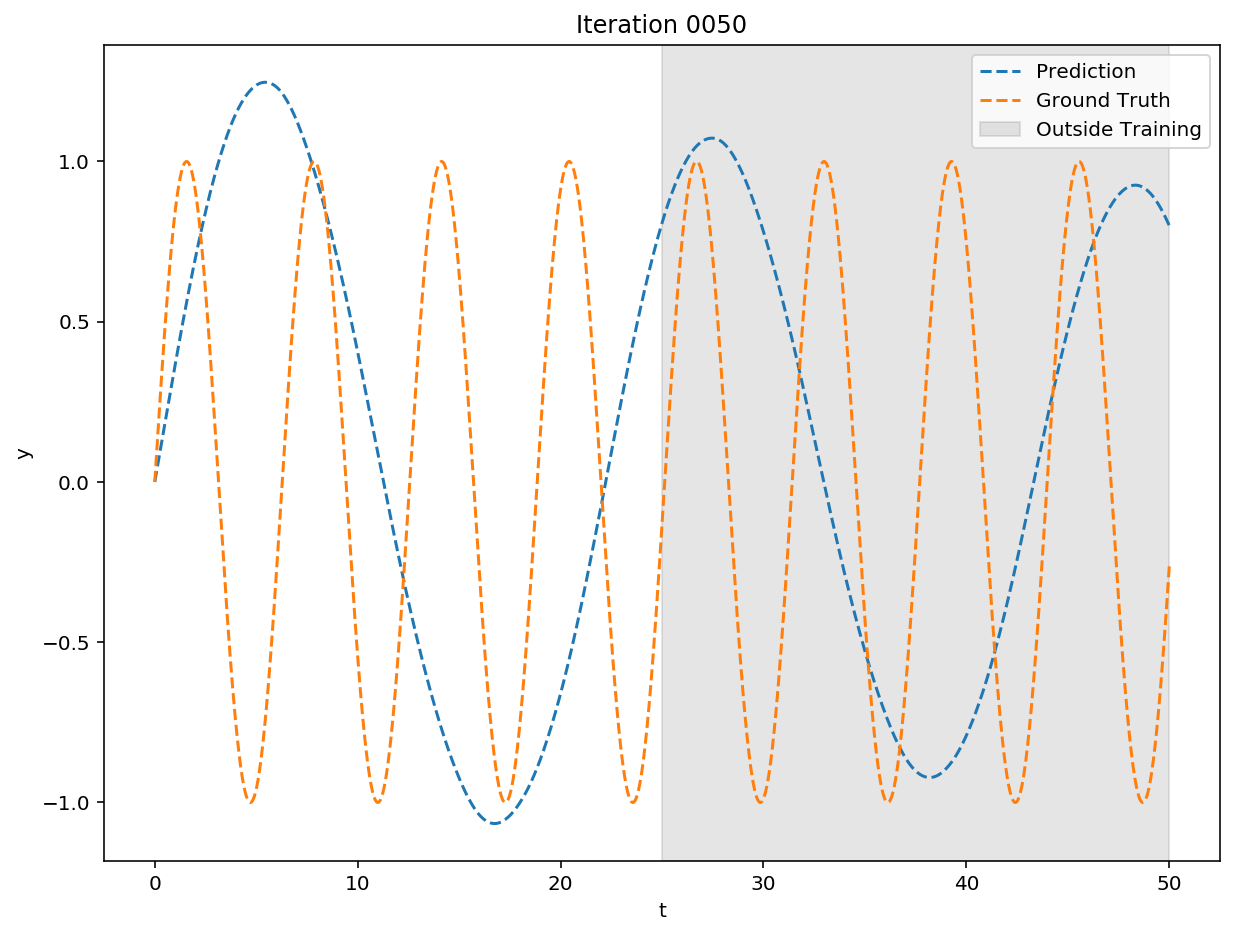

Iter 0100 | Total Loss 0.847254


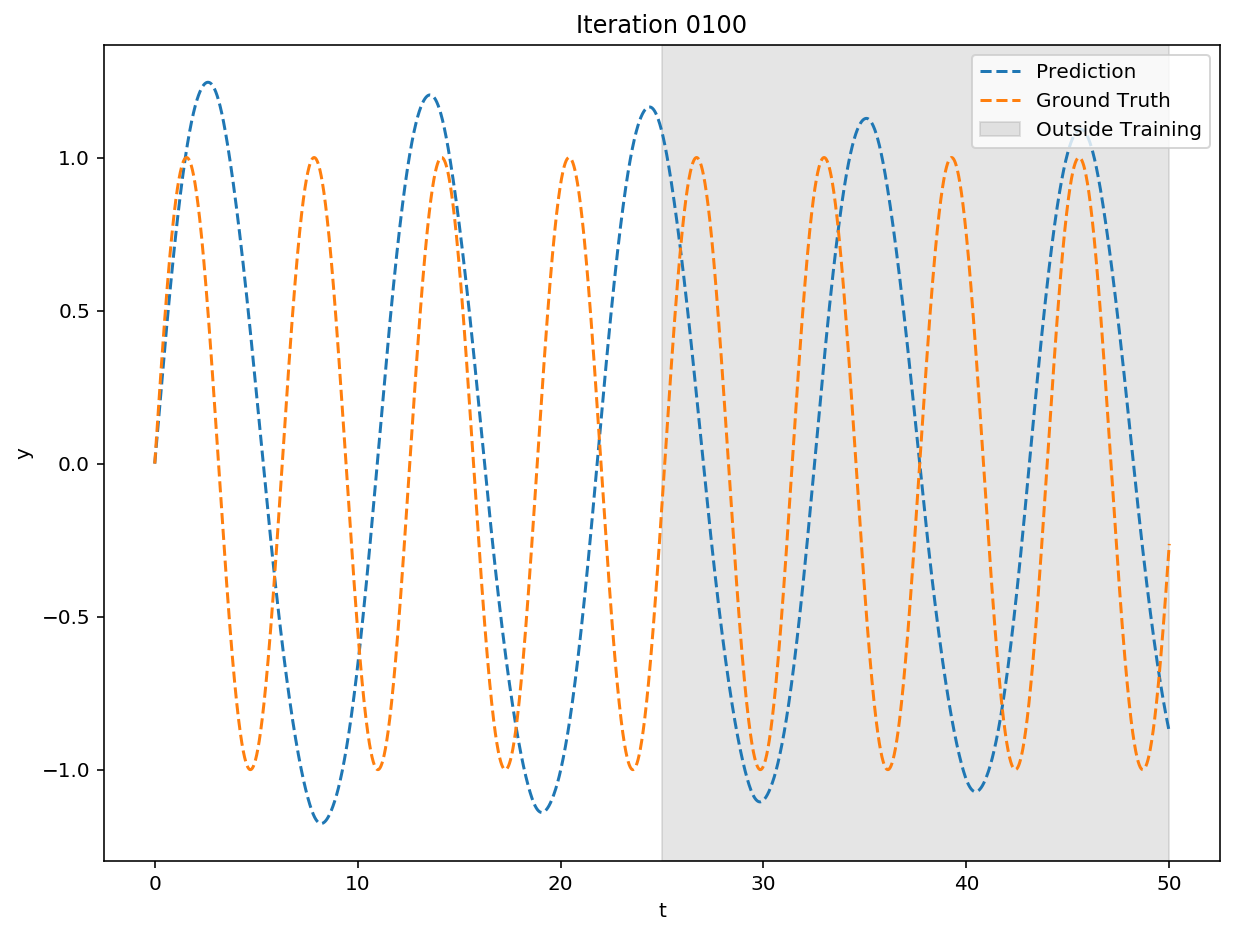

Iter 0150 | Total Loss 0.683075


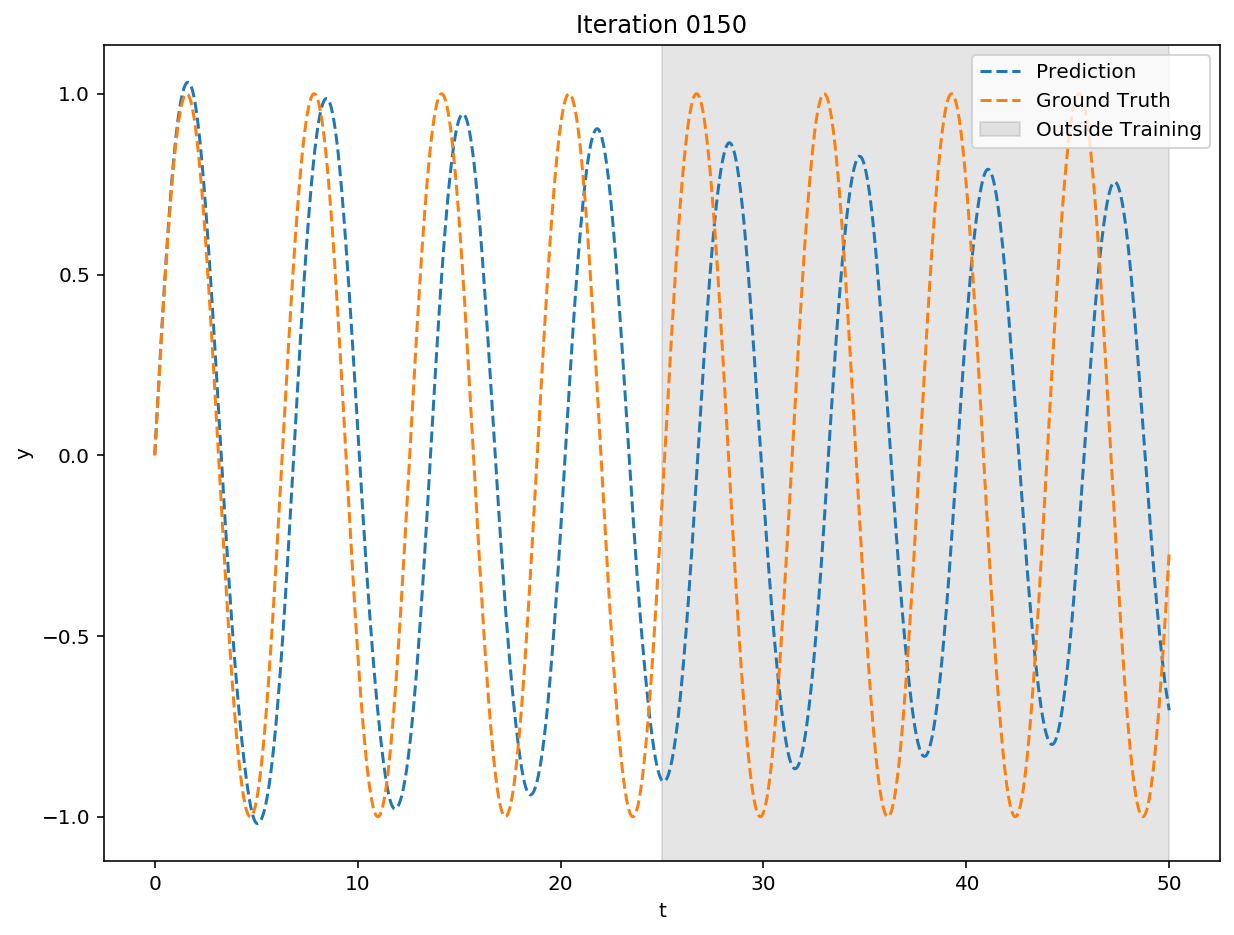

Iter 0200 | Total Loss 0.268209


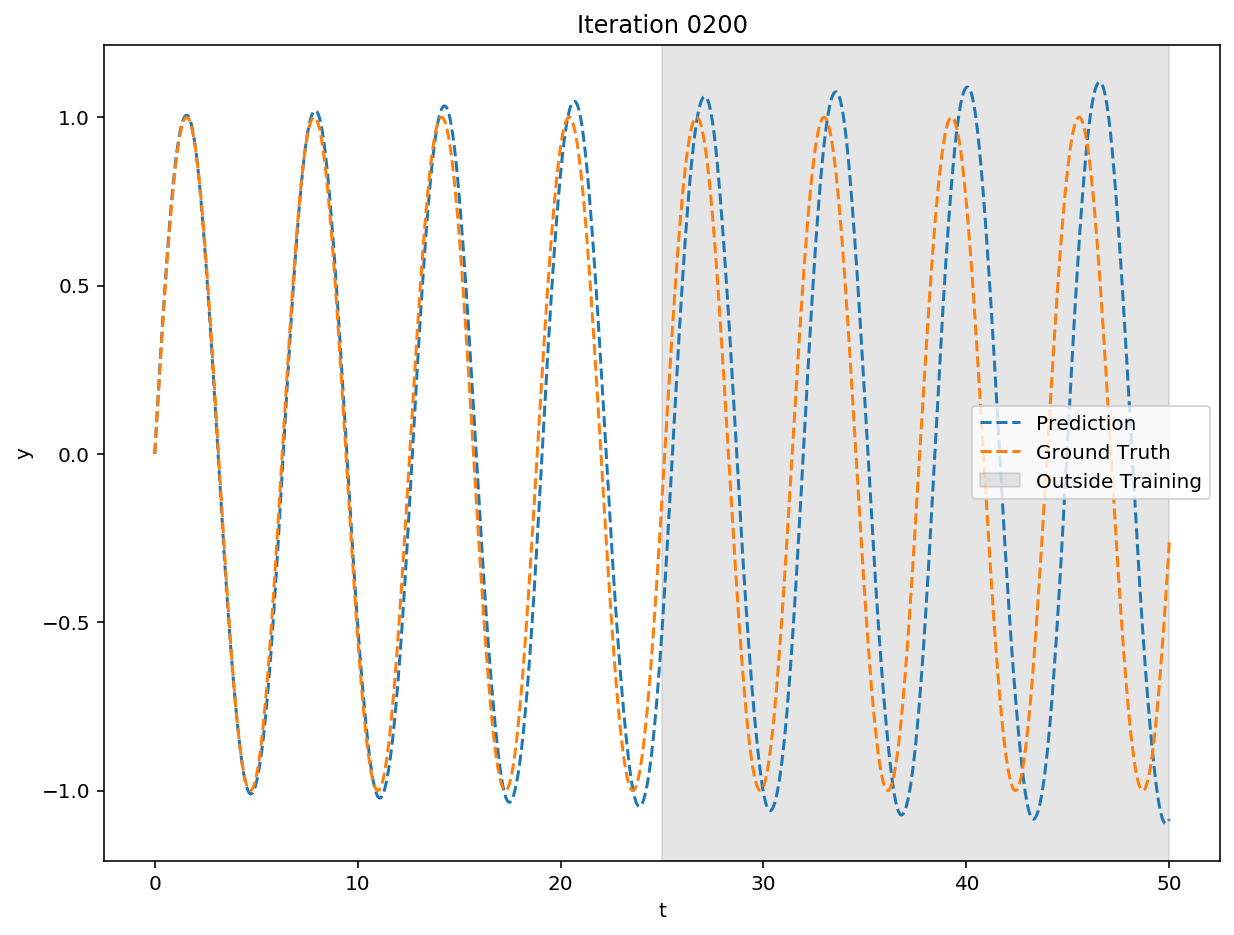

Iter 0250 | Total Loss 0.077167


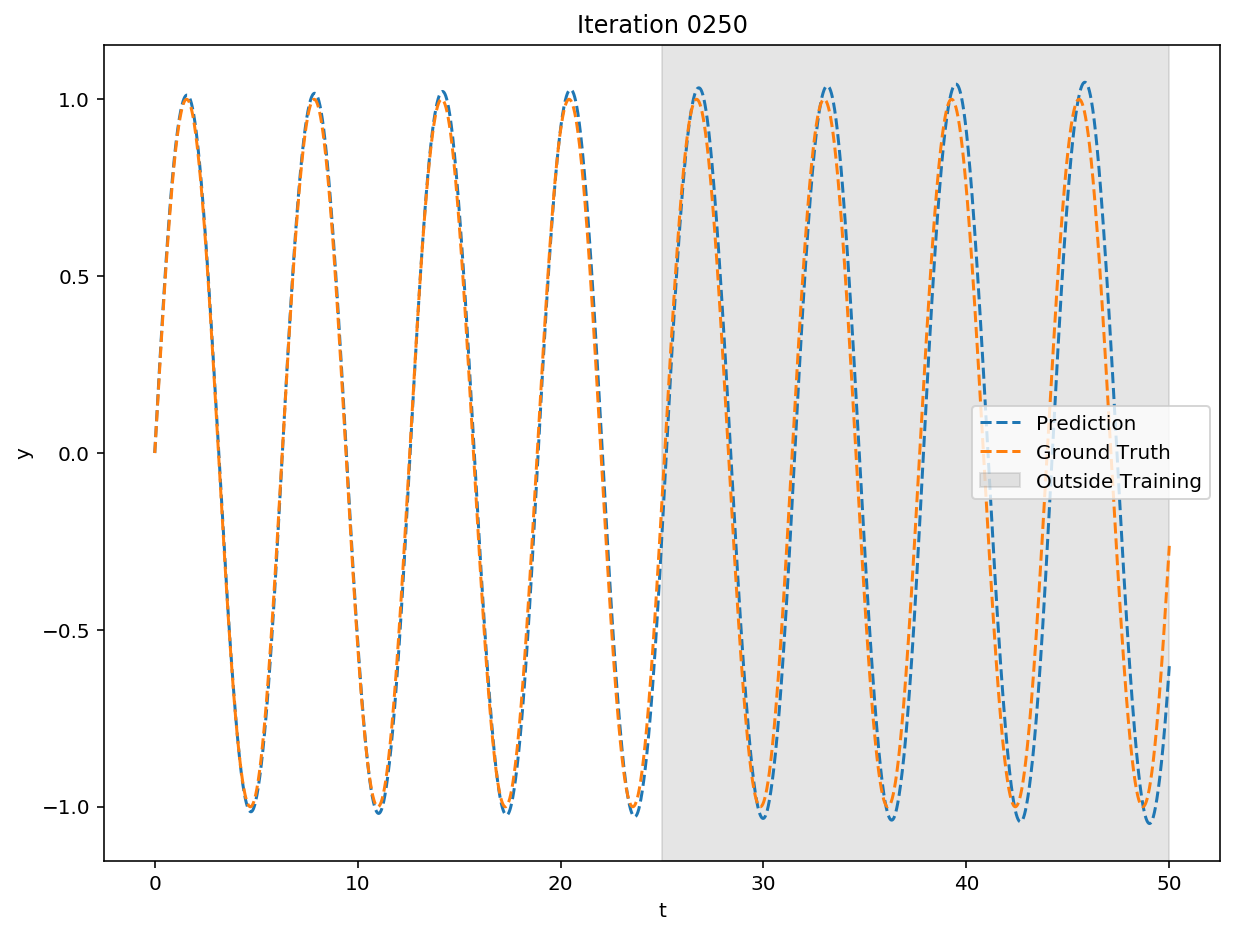

Iter 0300 | Total Loss 0.286204


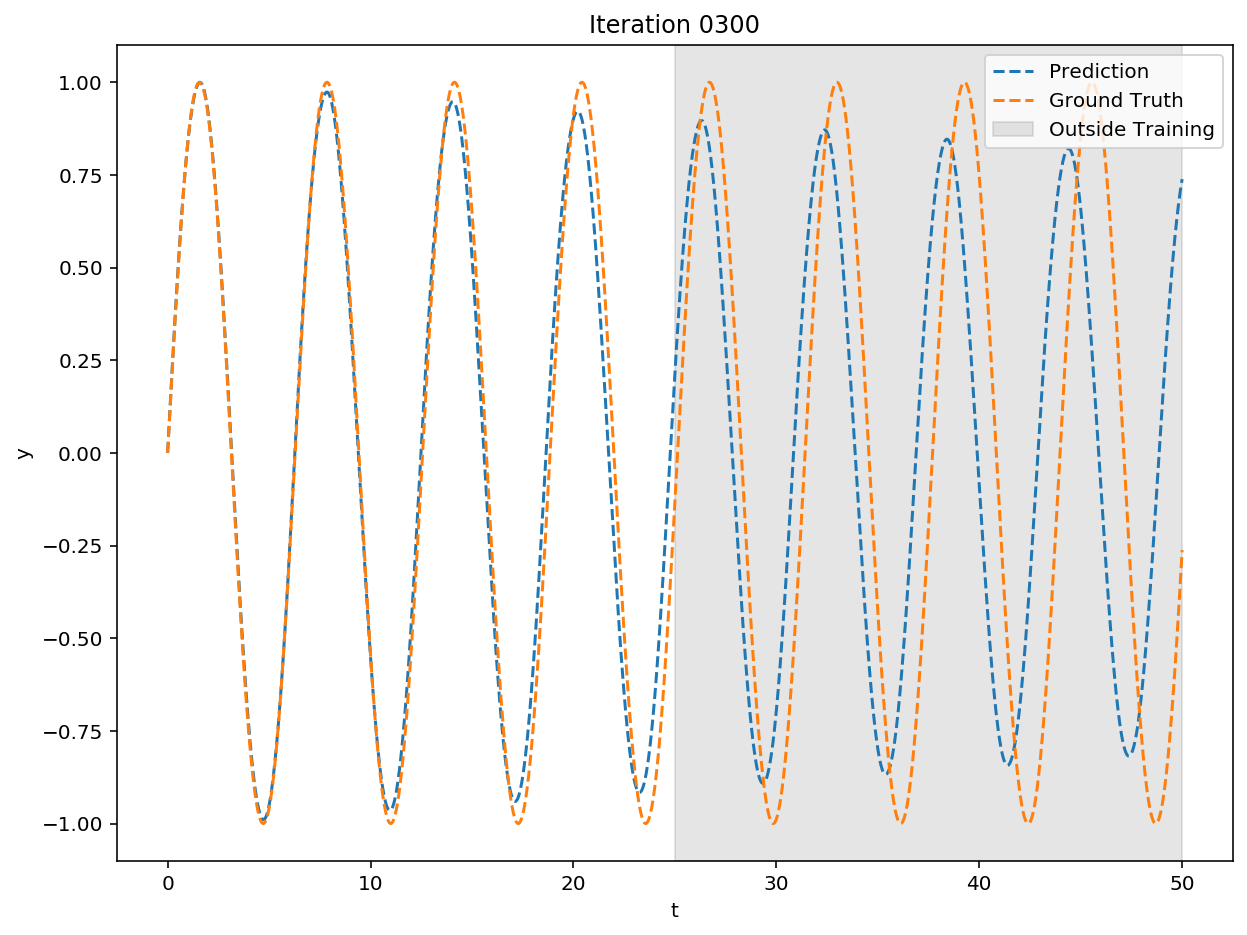

Iter 0350 | Total Loss 0.165503


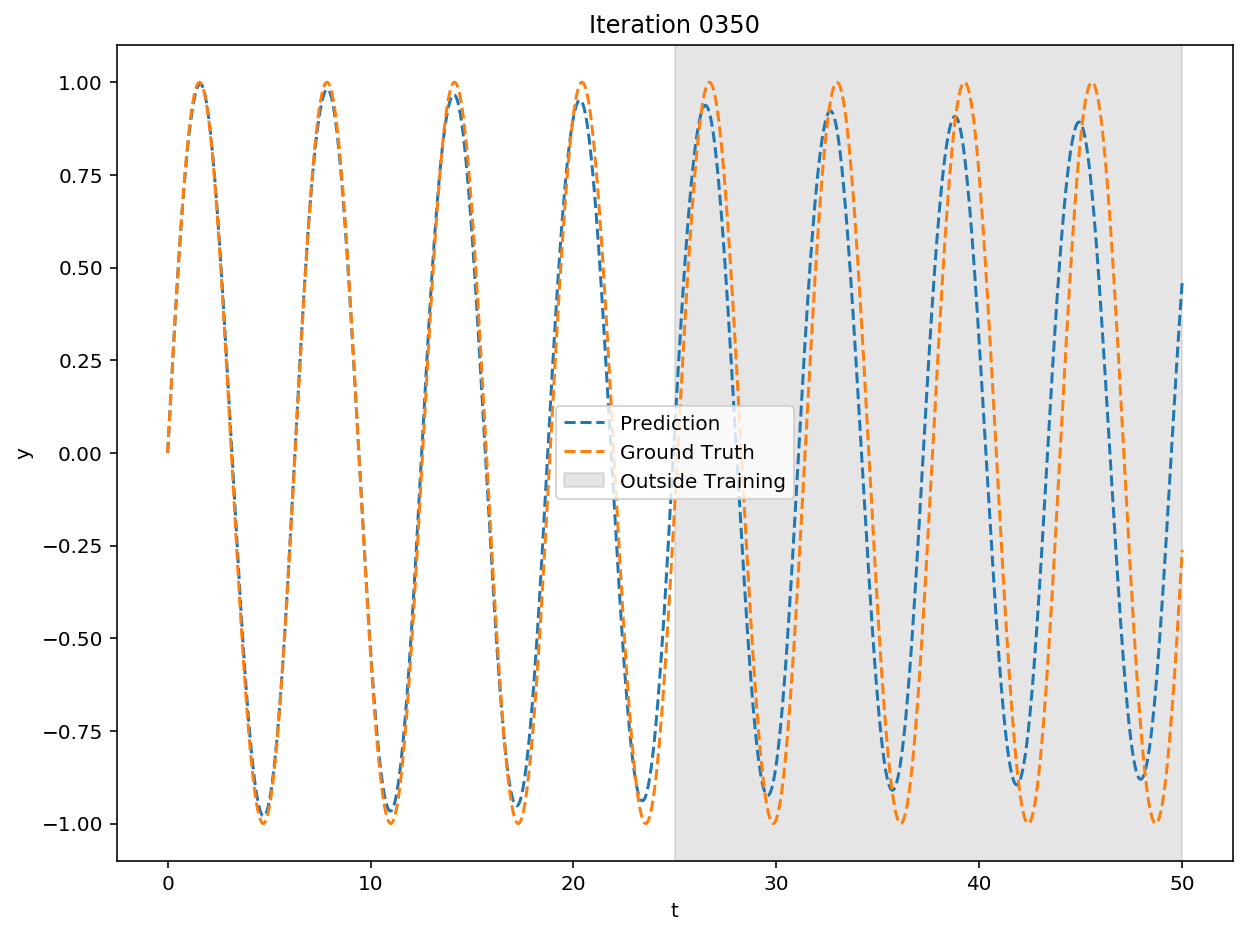

Iter 0400 | Total Loss 0.029548


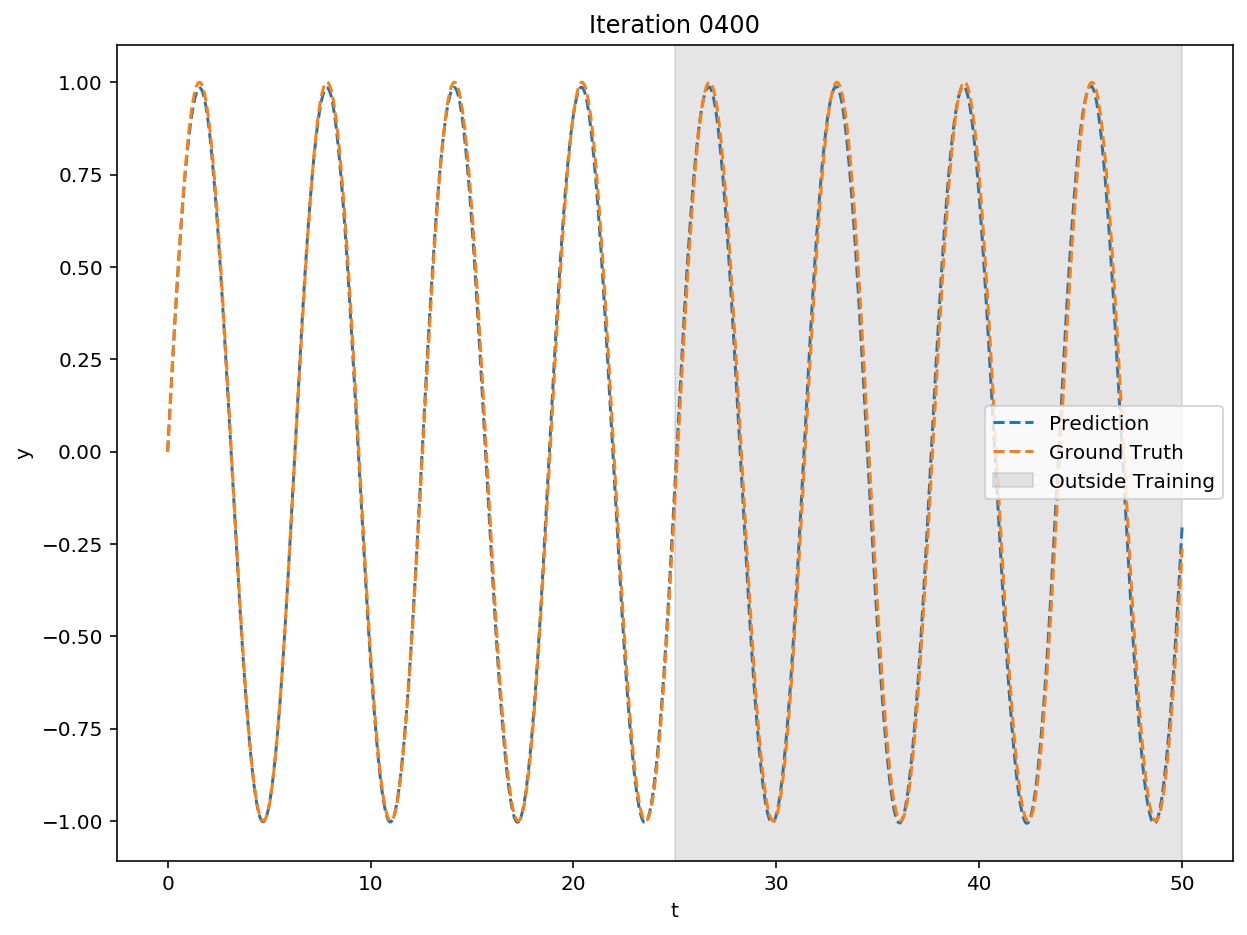

In [2]:
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint

# batch size
ts_size = 20

device = torch.device('cuda:' + str(0) if torch.cuda.is_available() else 'cpu')


class ODEFunc(nn.Module):
    """
    Neural Net of the ODE function
    """
    def __init__(self):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(nn.Linear(2, 10),
                                 nn.ReLU(),
                                 nn.Linear(10, 2))

        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.1)
                nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)


def get_batch():
    # randomly choosing 64 starting index in time index
    s = torch.from_numpy(np.random.choice(np.arange(size - ts_size, dtype=np.int64), 64, replace=False))
    batch_y0 = torch.Tensor(true_y[s])  # (M, D)
    batch_t = torch.Tensor(t[:ts_size])  # (T)
    batch_y = torch.Tensor(torch.stack([torch.Tensor(true_y[s + i]) for i in range(ts_size)], dim=0))  # (T, M, D)
    return batch_y0, batch_t, batch_y

ii = 0

func = ODEFunc()
optimizer = optim.RMSprop(func.parameters(), lr=1e-3)
end = time.time()

for itr in range(1, 2000 + 1):
    optimizer.zero_grad()
    batch_y0, batch_t, batch_y = get_batch()
    pred_y = odeint(func, batch_y0, batch_t)
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward()
    optimizer.step()

    if itr % 50 == 0:
        with torch.no_grad():
            test_t = np.linspace(0, 50, 2*size)
            pred_y = odeint(func, torch.Tensor(true_y0), torch.Tensor(test_t))
            test_true_y = scipy_odeint(ode_func, true_y0, test_t)
            loss = torch.mean(torch.abs(pred_y[:, 0] - test_true_y[:, 0]))
            pred = pred_y.detach().numpy()
            print(f'Iteration: {itr} | Total Loss {loss.item():.6f}')
            ii += 1
        plt.figure(figsize=(10, 7.5))
        plt.title(f"Iteration {itr}")
        plt.plot(test_t, pred_y[:, 0], c='C0', ls='--', label='Prediction')
        plt.plot(test_t, test_true_y[:, 0], c='C1', ls='--', label='Ground Truth')
        plt.axvspan(25, 50, color='gray', alpha=0.2, label='Outside Training')
        plt.xlabel('t')
        plt.ylabel('y')
        plt.legend(loc='best')
        plt.show()
        plt.close("all")

        if loss.item() < 0.05:
            break # early stopping if loss target is met

    end = time.time()
